The Network structure consists of three layers:
1. Input Layer(Flatten Layer):
- The grayscale images of 28*28 pixels
- Flattens the 2D images into 1D vectors of length 784
- This step doesn't involve any parameter so far
2. Hidden Layer:
- Contain 1000 neurons
- Use Rectified Linear Unit for the activation function
- This layer contains numerous parameters (784×1000 weights + 1000 bias terms), giving the network sufficient capacity to learn data features
3. Output Layer:
- Contains 10 neurons, corresponding to the ten digit classes 0-9
- Uses the Softmax activation function to convert outputs into a probability distribution



In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from backpack import backpack, extend
from backpack.extensions import BatchGrad
import torch.nn.functional as F

class SimpleModel(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=1000, output_dim=10):
        super(SimpleModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class PCASimpleModel(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=1000, output_dim=10):
        super(PCASimpleModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def set_pca_components(self, components):
        components_tensor = torch.FloatTensor(components)
        device = next(self.parameters()).device 
        components_tensor = components_tensor.to(device)
        self.register_buffer('pca_components', components_tensor)
        
    def forward(self, x):
        x = self.flatten(x)
        # print("x.shape", x.shape)
        if hasattr(self, 'pca_components') and self.pca_components is not None:
            x = torch.matmul(x, self.pca_components.t())
        # print("x.shape after PCA", x.shape)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CifarModel(nn.Module):
    def __init__(self, input_dim=3*32*32, hidden_dim=1024, output_dim=10):
        super(CifarModel, self).__init__()
        self.flatten = nn.Flatten()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

class PcaCifarModel(nn.Module):
    def __init__(self, input_dim=3*32*32, pca_dim=80, hidden_dim=1024, output_dim=10):
        super(PcaCifarModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(pca_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def set_pca_components(self, components):
        components_tensor = torch.FloatTensor(components)
        device = next(self.parameters()).device 
        components_tensor = components_tensor.to(device)
        self.register_buffer('pca_components', components_tensor)
        
    def forward(self, x):
        x = self.flatten(x)
        if hasattr(self, 'pca_components') and self.pca_components is not None:
            x = torch.matmul(x, self.pca_components.t())
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Learning Rate Scheduler

In [2]:
def get_lr_scheduler(optimizer, epochs):
    def lr_lamda(epoch):
        if epoch < 10:
            return 0.1 - (0.1 - 0.052) * (epoch / 10)
        else :
            return 0.052
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lamda)

MNIST Training

In [6]:
from utils import process_grad_batch, get_sigma
import time

def train_with_dp(model, train_loader, epochs, learning_rate, epsilon, delta, clip_norm=1.0):
    batch_size = train_loader.batch_size
    n_samples = len(train_loader.dataset)
    sample_probability = batch_size / n_samples
    steps = len(train_loader)
    total_steps = epochs * steps
    sigma, epsilon = get_sigma(sample_probability, total_steps, epsilon, delta)
    
    criterion = extend(nn.CrossEntropyLoss(reduction='sum'))
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    scheduler = get_lr_scheduler(optimizer, epochs)
    
    device = next(model.parameters()).device
    model.train()
    
    train_accuracies = []
    train_times = []
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        correct = 0
        train_loss = 0
        total = 0
        
        for inputs, targets in train_loader:
            
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            with backpack(BatchGrad()):
                loss.backward()
                
                process_grad_batch(list(model.parameters()), clip_norm)
                
                for p in model.parameters():
                    if p.requires_grad and p.grad is not None:
                        
                        # Add Gaussian noise to the gradients
                        noise = torch.normal(
                            mean= 0,
                            std= sigma * clip_norm / batch_size,
                            size= p.grad.shape,
                            device= p.grad.device
                        )
                        p.grad += noise
            
            optimizer.step()
            train_loss += loss.item() / inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        epoch_time = time.time() - epoch_start
        train_times.append(epoch_time)
        accuracy = 100 * correct / total
        train_accuracies.append(accuracy)
            
        scheduler.step()
            
        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/total:.4f}, ' +
              f'Accuracy: {accuracy:.2f}%, Time: {epoch_time:.2f}s')
        
    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return model, train_accuracies, train_times, total_time
    
def train_without_dp(model, train_loader, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    device = next(model.parameters()).device
    model.train()
    
    train_accuracies = []
    train_times = []
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        correct = 0
        train_loss = 0
        total = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        epoch_time = time.time() - epoch_start
        train_times.append(epoch_time)
        accuracy = 100 * correct / total
        train_accuracies.append(accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/total:.4f}, ' +
              f'Accuracy: {accuracy:.2f}%, Time: {epoch_time:.2f}s')
    
    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    
    return model, train_accuracies, train_times, total_time

Test Model

In [3]:
def test_model(model, test_loader):
    model.eval()
    test_loss = 0 
    correct = 0
    
    device = next(model.parameters()).device
    criterion = nn.CrossEntropyLoss(reduction='sum')
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)')
    
    return accuracy
    

Load MNIST, MNIST is a classic machine learning dataset containing a large number of handwritten digit imagmes(from 0 to 9), with each image size at 28*28 pixels.


In [15]:
from torchvision import transforms
from torchvision import datasets

def main():
    
    """Paper Parameters"""
    batch_size = 600 
    lr= 0.1
    epochs = 100
    epsilon = 2
    delta = 1e-5
    clip_norm = 4
    
    """ Load MNIST Dataset """
    trainform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=trainform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=trainform)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
    model = SimpleModel().to(device)
    model = extend(model)
    
    train_model = train_with_dp(model, train_loader, epochs, lr, epsilon, delta, clip_norm)
    
    torch.save(train_model.state_dict(), 'mnist_dp_model.pth')
    
    test_model(train_model, test_loader)
    
if __name__ == '__main__':
    main()

/home/tommy/miniconda3/envs/DataPrivacy/lib/python3.12/site-packages/backpack/extensions/backprop_extension.py:107: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.SimpleModel'> although the module has parameters
  warnings.warn(


Epoch 1/100, Loss: 0.0036721329786512593, Accuracy: 0.3902
Epoch 2/100, Loss: 0.0032837869974772123, Accuracy: 0.6705666666666666
Epoch 3/100, Loss: 0.002887451504177518, Accuracy: 0.7024
Epoch 4/100, Loss: 0.0025174152679443367, Accuracy: 0.7141833333333333
Epoch 5/100, Loss: 0.0022092158593071828, Accuracy: 0.7258333333333333
Epoch 6/100, Loss: 0.00196254738023546, Accuracy: 0.74585
Epoch 7/100, Loss: 0.00177384029812283, Accuracy: 0.7628
Epoch 8/100, Loss: 0.001626725626627604, Accuracy: 0.7782166666666667
Epoch 9/100, Loss: 0.0015112150115966793, Accuracy: 0.79005
Epoch 10/100, Loss: 0.001421371757507324, Accuracy: 0.79835
Epoch 11/100, Loss: 0.0013488293762207036, Accuracy: 0.8069666666666667
Epoch 12/100, Loss: 0.0012893528467814136, Accuracy: 0.8123
Epoch 13/100, Loss: 0.0012378559256659618, Accuracy: 0.8169
Epoch 14/100, Loss: 0.001190820870293511, Accuracy: 0.8221333333333334
Epoch 15/100, Loss: 0.0011496577996147998, Accuracy: 0.8259666666666666
Epoch 16/100, Loss: 0.00111197

Load CIFAR-10

In [10]:
def run_cifar_experiment():
    """Parameters for CIFAR"""
    batch_size = 128 #GPU Not Enough  
    lr = 0.01 
    epochs = 200
    epsilon = 2
    delta = 1e-5
    clip_norm = 4
    pca_dim = 80 
    pca_epsilon = 0.5
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    print("\n\n==== CIFAR Experiment 1: Without DP, Without PCA ====")
    model1 = CifarModel().to(device) 
    model1, acc1, times1, total_time1 = train_without_dp(model1, train_loader, epochs, lr)
    test_acc1 = test_model(model1, test_loader)
    
    print("\n\n==== CIFAR Experiment 2: With DP, Without PCA ====")
    model2 = CifarModel().to(device)
    model2 = extend(model2)
    model2, acc2, times2, total_time2 = train_with_dp(model2, train_loader, epochs, lr, epsilon, delta, clip_norm)
    test_acc2 = test_model(model2, test_loader)
    
    print("\n\n==== CIFAR Results Summary ====")
    print(f"{'Configuration':<25} {'Test Accuracy':<15} {'Training Time':<15}")
    print("-" * 55)
    print(f"{'Without DP, Without PCA':<25} {test_acc1:.2f}%{'':<10} {total_time1:.2f}s")
    print(f"{'With DP, Without PCA':<25} {test_acc2:.2f}%{'':<10} {total_time2:.2f}s")
    
    return {
        'without_dp_without_pca': {
            'train_accuracies': acc1,
            'test_accuracy': test_acc1,
            'total_time': total_time1
        },
        'with_dp_without_pca': {
            'train_accuracies': acc2,
            'test_accuracy': test_acc2,
            'total_time': total_time2
        }
    }
    
def plot_cifar_results(results):
    """
    為 CIFAR 實驗結果生成圖表
    """
    import matplotlib.pyplot as plt
    
    # 提取數據
    acc_without_dp_without_pca = results['without_dp_without_pca']['train_accuracies']
    acc_with_dp_without_pca = results['with_dp_without_pca']['train_accuracies']
    
    # 如果有 PCA 的實驗結果
    if 'without_dp_with_pca' in results and 'with_dp_with_pca' in results:
        acc_without_dp_with_pca = results['without_dp_with_pca']['train_accuracies']
        acc_with_dp_with_pca = results['with_dp_with_pca']['train_accuracies']
        has_pca_results = True
    else:
        has_pca_results = False
    
    # 提取時間數據 (如果有)
    if 'train_times' in results['without_dp_without_pca']:
        times_without_dp_without_pca = results['without_dp_without_pca']['train_times']
        times_with_dp_without_pca = results['with_dp_without_pca']['train_times']
        
        if has_pca_results:
            times_without_dp_with_pca = results['without_dp_with_pca']['train_times']
            times_with_dp_with_pca = results['with_dp_with_pca']['train_times']
        
        has_time_data = True
    else:
        has_time_data = False
    
    # 創建圖表
    plt.figure(figsize=(15, 6))
    
    # 訓練準確率圖
    plt.subplot(1, 2, 1)
    epochs = range(1, len(acc_without_dp_without_pca) + 1)
    
    plt.plot(epochs, acc_without_dp_without_pca, 'o-', label='Without DP, Without PCA')
    plt.plot(epochs, acc_with_dp_without_pca, 'o-', label='With DP, Without PCA')
    
    if has_pca_results:
        plt.plot(epochs, acc_without_dp_with_pca, 'o-', label='Without DP, With PCA')
        plt.plot(epochs, acc_with_dp_with_pca, 'o-', label='With DP, With PCA')
    
    plt.title('CIFAR-10: Training Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy (%)')
    plt.grid(True)
    plt.legend()
    
    # 訓練時間圖 (如果有時間數據)
    if has_time_data:
        plt.subplot(1, 2, 2)
        
        plt.plot(epochs, times_without_dp_without_pca, 'o-', label='Without DP, Without PCA')
        plt.plot(epochs, times_with_dp_without_pca, 'o-', label='With DP, Without PCA')
        
        if has_pca_results:
            plt.plot(epochs, times_without_dp_with_pca, 'o-', label='Without DP, With PCA')
            plt.plot(epochs, times_with_dp_with_pca, 'o-', label='With DP, With PCA')
        
        plt.title('CIFAR-10: Training Time vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Time per Epoch (s)')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('cifar_results.png')
    plt.show()
    
    # 生成測試準確率比較圖
    plt.figure(figsize=(10, 6))
    
    configurations = ['Without DP, Without PCA', 'With DP, Without PCA']
    test_accs = [
        results['without_dp_without_pca']['test_accuracy'],
        results['with_dp_without_pca']['test_accuracy']
    ]
    
    if has_pca_results:
        configurations.extend(['Without DP, With PCA', 'With DP, With PCA'])
        test_accs.extend([
            results['without_dp_with_pca']['test_accuracy'],
            results['with_dp_with_pca']['test_accuracy']
        ])
    
    plt.bar(configurations, test_accs, color=['blue', 'orange', 'green', 'red'][:len(configurations)])
    plt.title('CIFAR-10: Test Accuracy Comparison')
    plt.ylabel('Test Accuracy (%)')
    plt.grid(axis='y')
    
    # 在每個柱狀圖上添加數值標籤
    for i, v in enumerate(test_accs):
        plt.text(i, v + 1, f"{v:.2f}%", ha='center')
    
    plt.tight_layout()
    plt.savefig('cifar_test_accuracy.png')
    plt.show()
    
    # 輸出總結
    print("\n==== CIFAR-10 Results Summary ====")
    print(f"{'Configuration':<25} {'Test Accuracy':<15} {'Total Training Time':<20}")
    print("-" * 60)
    
    print(f"{'Without DP, Without PCA':<25} {results['without_dp_without_pca']['test_accuracy']:.2f}%{'':<10} {results['without_dp_without_pca'].get('total_time', 'N/A')}")
    print(f"{'With DP, Without PCA':<25} {results['with_dp_without_pca']['test_accuracy']:.2f}%{'':<10} {results['with_dp_without_pca'].get('total_time', 'N/A')}")
    
    if has_pca_results:
        print(f"{'Without DP, With PCA':<25} {results['without_dp_with_pca']['test_accuracy']:.2f}%{'':<10} {results['without_dp_with_pca'].get('total_time', 'N/A')}")
        print(f"{'With DP, With PCA':<25} {results['with_dp_with_pca']['test_accuracy']:.2f}%{'':<10} {results['with_dp_with_pca'].get('total_time', 'N/A')}")
    

MNIST Main

Using device: cuda
Computing differentially private PCA...
PCA completed with 60 components


==== Experiment 1: Without DP, Without PCA ====
Epoch 1/100, Loss: 1.0984, Accuracy: 77.58%, Time: 1.23s
Epoch 2/100, Loss: 0.4543, Accuracy: 88.22%, Time: 1.21s
Epoch 3/100, Loss: 0.3713, Accuracy: 89.80%, Time: 1.21s
Epoch 4/100, Loss: 0.3339, Accuracy: 90.58%, Time: 1.22s
Epoch 5/100, Loss: 0.3097, Accuracy: 91.26%, Time: 1.40s
Epoch 6/100, Loss: 0.2910, Accuracy: 91.83%, Time: 1.25s
Epoch 7/100, Loss: 0.2753, Accuracy: 92.33%, Time: 1.21s
Epoch 8/100, Loss: 0.2611, Accuracy: 92.72%, Time: 1.22s
Epoch 9/100, Loss: 0.2492, Accuracy: 93.04%, Time: 1.22s
Epoch 10/100, Loss: 0.2380, Accuracy: 93.31%, Time: 1.23s
Epoch 11/100, Loss: 0.2279, Accuracy: 93.68%, Time: 1.23s
Epoch 12/100, Loss: 0.2187, Accuracy: 93.93%, Time: 1.21s
Epoch 13/100, Loss: 0.2099, Accuracy: 94.17%, Time: 1.21s
Epoch 14/100, Loss: 0.2019, Accuracy: 94.38%, Time: 1.33s
Epoch 15/100, Loss: 0.1943, Accuracy: 94.57%, Time: 1.2

/home/tommy/miniconda3/envs/DataPrivacy/lib/python3.12/site-packages/backpack/extensions/backprop_extension.py:107: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.SimpleModel'> although the module has parameters
  warnings.warn(


Epoch 1/100, Loss: 0.0036, Accuracy: 44.62%, Time: 2.83s
Epoch 2/100, Loss: 0.0032, Accuracy: 65.13%, Time: 2.82s
Epoch 3/100, Loss: 0.0029, Accuracy: 69.36%, Time: 2.82s
Epoch 4/100, Loss: 0.0025, Accuracy: 71.11%, Time: 2.84s
Epoch 5/100, Loss: 0.0022, Accuracy: 73.01%, Time: 2.83s
Epoch 6/100, Loss: 0.0019, Accuracy: 75.16%, Time: 2.84s
Epoch 7/100, Loss: 0.0018, Accuracy: 76.47%, Time: 2.86s
Epoch 8/100, Loss: 0.0016, Accuracy: 77.64%, Time: 2.83s
Epoch 9/100, Loss: 0.0015, Accuracy: 78.65%, Time: 2.93s
Epoch 10/100, Loss: 0.0014, Accuracy: 79.42%, Time: 2.83s
Epoch 11/100, Loss: 0.0013, Accuracy: 80.12%, Time: 2.83s
Epoch 12/100, Loss: 0.0013, Accuracy: 80.58%, Time: 2.83s
Epoch 13/100, Loss: 0.0012, Accuracy: 81.18%, Time: 2.83s
Epoch 14/100, Loss: 0.0012, Accuracy: 81.76%, Time: 2.83s
Epoch 15/100, Loss: 0.0011, Accuracy: 82.19%, Time: 2.84s
Epoch 16/100, Loss: 0.0011, Accuracy: 82.64%, Time: 2.83s
Epoch 17/100, Loss: 0.0011, Accuracy: 82.99%, Time: 2.85s
Epoch 18/100, Loss: 0.0

/home/tommy/miniconda3/envs/DataPrivacy/lib/python3.12/site-packages/backpack/extensions/backprop_extension.py:107: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.PCASimpleModel'> although the module has parameters
  warnings.warn(


Epoch 1/100, Loss: 0.0034, Accuracy: 47.60%, Time: 1.42s
Epoch 2/100, Loss: 0.0026, Accuracy: 66.43%, Time: 1.43s
Epoch 3/100, Loss: 0.0021, Accuracy: 69.16%, Time: 1.42s
Epoch 4/100, Loss: 0.0018, Accuracy: 71.56%, Time: 1.43s
Epoch 5/100, Loss: 0.0016, Accuracy: 73.93%, Time: 1.42s
Epoch 6/100, Loss: 0.0015, Accuracy: 75.85%, Time: 1.42s
Epoch 7/100, Loss: 0.0014, Accuracy: 77.08%, Time: 1.43s
Epoch 8/100, Loss: 0.0013, Accuracy: 77.98%, Time: 1.53s
Epoch 9/100, Loss: 0.0012, Accuracy: 78.89%, Time: 1.43s
Epoch 10/100, Loss: 0.0012, Accuracy: 79.47%, Time: 1.44s
Epoch 11/100, Loss: 0.0011, Accuracy: 80.11%, Time: 1.43s
Epoch 12/100, Loss: 0.0011, Accuracy: 80.53%, Time: 1.43s
Epoch 13/100, Loss: 0.0011, Accuracy: 80.92%, Time: 1.44s
Epoch 14/100, Loss: 0.0011, Accuracy: 81.39%, Time: 1.44s
Epoch 15/100, Loss: 0.0010, Accuracy: 81.75%, Time: 1.44s
Epoch 16/100, Loss: 0.0010, Accuracy: 82.08%, Time: 1.44s
Epoch 17/100, Loss: 0.0010, Accuracy: 82.28%, Time: 1.42s
Epoch 18/100, Loss: 0.0

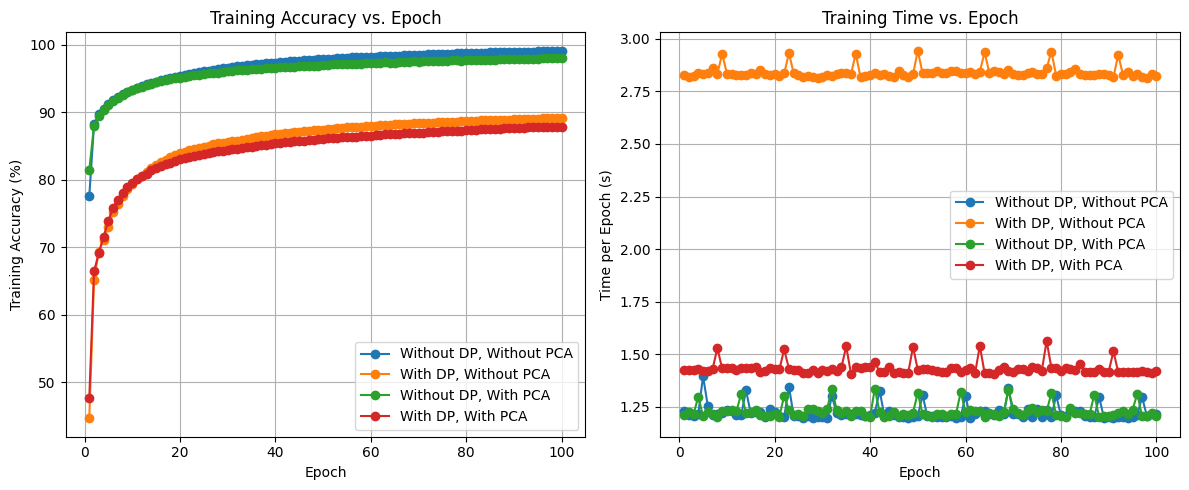

Models saved. Experiment completed!


In [ ]:
import matplotlib.pyplot as plt
import time

def run_comparison_experiment():
    # 基本設置
    batch_size = 600
    lr = 0.1
    epochs = 100
    epsilon = 2
    delta = 1e-5
    clip_norm = 4
    pca_dim = 60
    pca_epsilon = 0.5
    
    # 設置設備
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # 載入數據
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    # 創建數據加載器
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    # 計算PCA組件（一次計算，多次使用）
    print("Computing differentially private PCA...")
    all_data, _ = next(iter(torch.utils.data.DataLoader(
        dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)))
    
    pca_components = differentially_private_pca(
        all_data, n_components=pca_dim, epsilon=pca_epsilon, delta=delta)
    print(f"PCA completed with {pca_dim} components")
    
    # 準備存儲結果
    results = {
        'without_dp_without_pca': {},
        'with_dp_without_pca': {},
        'without_dp_with_pca': {},
        'with_dp_with_pca': {}
    }
    
    # 實驗1: 沒有DP，沒有PCA
    print("\n\n==== Experiment 1: Without DP, Without PCA ====")
    model1 = SimpleModel(input_dim=784).to(device)
    model1, acc1, times1, total_time1 = train_without_dp(model1, train_loader, epochs, lr)
    test_acc1 = test_model(model1, test_loader)
    
    results['without_dp_without_pca'] = {
        'train_accuracies': acc1,
        'train_times': times1,
        'total_time': total_time1,
        'test_accuracy': test_acc1
    }
    
    # 實驗2: 有DP，沒有PCA
    print("\n\n==== Experiment 2: With DP, Without PCA ====")
    model2 = SimpleModel(input_dim=784).to(device)
    model2 = extend(model2)
    model2, acc2, times2, total_time2 = train_with_dp(model2, train_loader, epochs, lr, epsilon, delta, clip_norm)
    test_acc2 = test_model(model2, test_loader)
    
    results['with_dp_without_pca'] = {
        'train_accuracies': acc2,
        'train_times': times2,
        'total_time': total_time2,
        'test_accuracy': test_acc2
    }
    
    # 實驗3: 沒有DP，有PCA
    print("\n\n==== Experiment 3: Without DP, With PCA ====")
    model3 = PCASimpleModel(input_dim=pca_dim).to(device)
    model3.set_pca_components(pca_components)
    model3, acc3, times3, total_time3 = train_without_dp(model3, train_loader, epochs, lr)
    test_acc3 = test_model(model3, test_loader)
    
    results['without_dp_with_pca'] = {
        'train_accuracies': acc3,
        'train_times': times3,
        'total_time': total_time3,
        'test_accuracy': test_acc3
    }
    
    # 實驗4: 有DP，有PCA
    print("\n\n==== Experiment 4: With DP, With PCA ====")
    model4 = PCASimpleModel(input_dim=pca_dim).to(device)
    model4 = extend(model4)
    model4.set_pca_components(pca_components)
    train_epsilon = epsilon - pca_epsilon
    model4, acc4, times4, total_time4 = train_with_dp(model4, train_loader, epochs, lr, train_epsilon, delta, clip_norm)
    test_acc4 = test_model(model4, test_loader)
    
    results['with_dp_with_pca'] = {
        'train_accuracies': acc4,
        'train_times': times4,
        'total_time': total_time4,
        'test_accuracy': test_acc4
    }
    
    # 結果匯總和比較
    print("\n\n==== Results Summary ====")
    print(f"{'Configuration':<25} {'Test Accuracy':<15} {'Training Time':<15}")
    print("-" * 55)
    print(f"{'Without DP, Without PCA':<25} {test_acc1:.2f}%{'':<10} {total_time1:.2f}s")
    print(f"{'With DP, Without PCA':<25} {test_acc2:.2f}%{'':<10} {total_time2:.2f}s")
    print(f"{'Without DP, With PCA':<25} {test_acc3:.2f}%{'':<10} {total_time3:.2f}s")
    print(f"{'With DP, With PCA':<25} {test_acc4:.2f}%{'':<10} {total_time4:.2f}s")
    
    # 可視化準確率趨勢
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), acc1, 'o-', label='Without DP, Without PCA')
    plt.plot(range(1, epochs+1), acc2, 'o-', label='With DP, Without PCA')
    plt.plot(range(1, epochs+1), acc3, 'o-', label='Without DP, With PCA')
    plt.plot(range(1, epochs+1), acc4, 'o-', label='With DP, With PCA')
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy (%)')
    plt.title('Training Accuracy vs. Epoch')
    plt.legend()
    plt.grid(True)
    
    # 可視化每輪訓練時間
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), times1, 'o-', label='Without DP, Without PCA')
    plt.plot(range(1, epochs+1), times2, 'o-', label='With DP, Without PCA')
    plt.plot(range(1, epochs+1), times3, 'o-', label='Without DP, With PCA')
    plt.plot(range(1, epochs+1), times4, 'o-', label='With DP, With PCA')
    plt.xlabel('Epoch')
    plt.ylabel('Time per Epoch (s)')
    plt.title('Training Time vs. Epoch')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('comparison_results.png')
    plt.show()
    
    # 保存模型
    torch.save(model1.state_dict(), 'model_without_dp_without_pca.pth')
    torch.save(model2.state_dict(), 'model_with_dp_without_pca.pth')
    torch.save(model3.state_dict(), 'model_without_dp_with_pca.pth')
    torch.save(model4.state_dict(), 'model_with_dp_with_pca.pth')
    
    print("Models saved. Experiment completed!")
    return results

if __name__ == '__main__':
    run_comparison_experiment()

CIFAR-10 Main

In [ ]:
if __name__ == '__main__':
    cifar_results = run_cifar_experiment()
    plot_cifar_results(cifar_results)

Using device: cuda


==== CIFAR Experiment 1: Without DP, Without PCA ====
Epoch 1/200, Loss: 1.9834, Accuracy: 29.78%, Time: 3.11s
Epoch 2/200, Loss: 1.6251, Accuracy: 42.58%, Time: 3.09s
Epoch 3/200, Loss: 1.4541, Accuracy: 48.46%, Time: 3.08s
Epoch 4/200, Loss: 1.3469, Accuracy: 52.38%, Time: 3.09s
Epoch 5/200, Loss: 1.2688, Accuracy: 55.28%, Time: 3.10s
Epoch 6/200, Loss: 1.2032, Accuracy: 57.73%, Time: 3.10s
Epoch 7/200, Loss: 1.1475, Accuracy: 60.02%, Time: 3.09s
Epoch 8/200, Loss: 1.0949, Accuracy: 61.81%, Time: 3.08s
Epoch 9/200, Loss: 1.0485, Accuracy: 63.41%, Time: 3.08s
Epoch 10/200, Loss: 1.0011, Accuracy: 65.19%, Time: 3.09s
Epoch 11/200, Loss: 0.9606, Accuracy: 66.37%, Time: 3.08s
Epoch 12/200, Loss: 0.9197, Accuracy: 68.27%, Time: 3.08s
Epoch 13/200, Loss: 0.8808, Accuracy: 69.58%, Time: 3.08s
Epoch 14/200, Loss: 0.8430, Accuracy: 70.97%, Time: 3.09s
Epoch 15/200, Loss: 0.8058, Accuracy: 72.12%, Time: 3.08s
Epoch 16/200, Loss: 0.7701, Accuracy: 73.47%, Time: 3.09s
Epoch 